In [1]:
import sqlite3
import pandas as pd
import os
from sqlite3 import connect
import matplotlib.pyplot as plt
import torch
import transformers
import pysentimiento
from pysentimiento import create_analyzer
import os
import pickle
import re
import warnings
from pysentimiento.preprocessing import preprocess_tweet

In [ ]:
REQUIRED_POSTS_COLUMNS = {
    "author",
    "date",
    "content"
}
OPTIONAL_POSTS_COLUMNS = {"label"}

REQUIRED_AUTHORS_COLUMNS = {
    "author_screen_name",
    "friends_count",
    "followers_count",
    "statuses_count",
    "location"
}


In [ ]:
def validate_db_file(path):
    """Ensure the file is a SQLite .db file."""
    if not os.path.isfile(path):
        raise FileNotFoundError(f"File not found: {path}")
    if not path.lower().endswith(".db"):
        raise ValueError(f"Invalid file type: {path}. Must be a .db file.")

In [ ]:
def validate_columns(df, required_cols, optional_cols=None, table_name=""):
    """Ensure the required columns exist in the DataFrame."""
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns in {table_name} table: {missing}")
    if optional_cols:
        optional_missing = optional_cols - set(df.columns)
        if optional_missing:
            print(f"Note: Optional columns missing in {table_name} table: {optional_missing}")

In [2]:
def load_data(database_file, chunksize=1000, checkpoint_file="posts_checkpoint.pkl"):
    """
    Loads data from the database tables.
    Loads the authors table completely and loads the posts table in chunks with checkpoint support.
    
    Returns:
        tuple: (generator of posts chunks, authors_df)
    """
    checkpoint_file = str(checkpoint_file)
    validate_db_file(database_file)
    conn = sqlite3.connect(database_file)

    # Load authors table
    authors_query = "SELECT * FROM authors"
    authors_df = pd.read_sql_query(authors_query, conn)
    validate_columns(authors_df, REQUIRED_AUTHORS_COLUMNS, optional_cols=OPTIONAL_POSTS_COLUMNS, table_name="authors")

    # Load checkpoint if exists
    start_index = 0
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            start_index = pickle.load(f)
        print(f"Resuming posts from index: {start_index}")
    else:
        print("Starting from the beginning (posts index 0).")

    # Inner generator function for streaming the posts table
    def posts_generator():
        posts_query = "SELECT * FROM posts"
        posts_iter = pd.read_sql_query(posts_query, conn, chunksize=chunksize)
        global_index = 0

        for chunk in posts_iter:
            chunk_length = len(chunk)

            if global_index + chunk_length <= start_index:
                global_index += chunk_length
                continue

            if start_index > global_index:
                offset = start_index - global_index
                chunk = chunk.iloc[offset:]
                global_index += offset
            else:
                offset = 0

            global_index += len(chunk)

            validate_columns(chunk, REQUIRED_POSTS_COLUMNS, table_name="posts")

            os.makedirs(os.path.dirname(checkpoint_file) or ".", exist_ok=True)
            # Save checkpoint
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(global_index, f)

            yield chunk

    return posts_generator(), authors_df

In [3]:
def preprocess_data(tweets_df, authors_df):
    """Filter and preprocess the data."""
    filtered = authors_df['author_screen_name']
    tweets_df = tweets_df[tweets_df['author'].isin(filtered)]
    return tweets_df

In [4]:
def parse_date(date_str):
    try:
        # Try parsing with four-digit year first
        return pd.to_datetime(date_str, format='%Y-%m-%d')
    except ValueError:
        # If it fails, try parsing with two-digit year
        return pd.to_datetime(date_str, format='%y-%m-%d')

In [5]:
def clean_text(text):
    if not isinstance(text, str) or text == "":
        print("Invalid text input:", text)
        return ""

    # cleaning the text
    text = preprocess_tweet(text)
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s,.;!?-]', '', text)  # לנקות תווים חריגים שנותרו
    text = text.lower()
    return text


# Emotions model


In [15]:

def process_tweets(
    tweets_df,
    output_dir,
    # output_file,
    checkpoint_file,
    batch_size=1000,
    max_batches=10,
    lang="en",
    task="emotion",
    num_files=10
):
    """
    Processes tweets for analysis using a specified task and language model.
    
    Parameters:
        tweets_df (pd.DataFrame): DataFrame containing tweets. Must include 'content', 'author', and 'new_date' columns.
        output_file (str): Path to save the output file with analysis results.
        checkpoint_file (str): Path to save the checkpoint file for resuming progress.
        batch_size (int): Number of tweets to process in each batch. Default is 1000.
        max_batches (int): Maximum number of batches to process. Default is None (process all).
        lang (str): Language for the analysis model. Default is "en".
        task (str): Analysis task for the model (e.g., "emotion", "sentiment"). Default is "emotion".
    """
    # Set logging level for transformers
    transformers.logging.set_verbosity(transformers.logging.ERROR)

    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the analyzer for the specified task
    analyzer = create_analyzer(task=task, lang=lang)

    # Move the model to GPU if available
    analyzer.model.to(device)

    # Load checkpoint if it exists
    os.makedirs(output_dir, exist_ok=True)
    start_index = 0
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            start_index = pickle.load(f)
        print(f"Resuming from index: {start_index}")
    else:
        print("Starting from the beginning (index 0).")

    total_tweets = tweets_df.iloc[start_index:start_index + (batch_size * max_batches)]
    total_rows = len(total_tweets)
    rows_per_file = total_rows // num_files + (total_rows % num_files > 0)
    
    # Results container
    results = []
    file_counter = 1
    tweets_processed = 0
    
    # Process tweets in batches
    for batch_number, i in enumerate(range(start_index, start_index + total_rows, batch_size)):
        batch = tweets_df.iloc[i:i + batch_size]

        for _, tweet in batch.iterrows():
            content = tweet['content']
            if content:
                analysis_result = analyzer.predict(content)
                probabilities = analysis_result.probas if hasattr(analysis_result, "probas") else analysis_result.output
                formatted_probabilities = {k: f"{v:.3f}" for k, v in probabilities.items()}

                results.append({
                    'author': tweet['author'],
                    'new_date': tweet['new_date'],
                    'content': content,
                    **formatted_probabilities,
                })

            tweets_processed += 1

            # Save to file when reaching rows_per_file
            if len(results) >= rows_per_file or tweets_processed >= total_rows:
                output_file = os.path.join(output_dir, f"{task}_results_part{file_counter}.csv")
                df = pd.DataFrame(results)
                df.to_csv(output_file, sep=',', encoding='utf-8', index=False, header=True)
                print(f"Saved {len(results)} rows to {output_file}")

                results = []
                file_counter += 1
        with open(checkpoint_file, 'wb') as f:
            pickle.dump(i + batch_size, f)

        print(f"Processed batch {batch_number + 1}")

    print("All tweets have been processed and saved.")




# Results

# Visual Representation 


In [7]:
def calculate_monthly_author_means(df, task_columns):
    """
    Calculate the monthly mean values for the specified task columns per author.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'author', 'new_date', and task-specific columns.
        task_columns (list): A list of columns related to the task (e.g., emotion or sentiment scores).

    Returns:
        pd.DataFrame: A DataFrame with monthly mean values per author for the specified task columns.
    """
    # Convert new_date to datetime if not already
    df['new_date'] = pd.to_datetime(df['new_date'])
    
    # Extract year-month for grouping
    df['year_month'] = df['new_date'].dt.to_period('M')
    
    # Prepare the aggregation dictionary dynamically
    agg_dict = {col: 'mean' for col in task_columns}
    
    # Calculate mean values per author per month
    monthly_author_means = df.groupby(['author', 'year_month']).agg(agg_dict).reset_index()
    
    return monthly_author_means


In [8]:
def calculate_mean_over_time(df, group_by_column, date_column, task_columns):
    """
    Calculate mean probabilities over time for specified task columns.

    Args:
        df (pd.DataFrame): DataFrame containing the data to analyze.
        group_by_column (str): Column name to group by (e.g., 'author').
        date_column (str): Column name containing date information.
        task_columns (list): List of task-specific columns to calculate mean values for.

    Returns:
        pd.DataFrame: A DataFrame with mean probabilities for each date and group.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract year-month for grouping
    df['year_month'] = df[date_column].dt.to_period('M')
    
    # Aggregate task columns and calculate mean values grouped by author and year_month
    agg_dict = {col: 'mean' for col in task_columns}
    mean_over_time = df.groupby([group_by_column, 'year_month']).agg(agg_dict).reset_index()
    
    return mean_over_time

In [9]:
def calculate_mean_of_means(monthly_author_means, task_columns):
    """
    Calculate the mean of the task-specific columns across all authors for each month.

    Args:
        monthly_author_means (pd.DataFrame): DataFrame containing aggregated task-specific columns per author per month.
        task_columns (list): A list of task-specific columns to calculate the mean of means.

    Returns:
        pd.DataFrame: A DataFrame with monthly mean values for the specified task columns.
    """
    # Prepare the aggregation dictionary dynamically
    agg_dict = {col: 'mean' for col in task_columns}
    
    # Calculate mean of each task column across all authors for each month
    monthly_means = monthly_author_means.groupby('year_month').agg(agg_dict).reset_index()
    
    return monthly_means

In [10]:
def plot_trends(group_dataframes, task_columns, group_names, save_dir=None):
    """
    Plot trends for task-specific columns for multiple social groups and save as PNG files.

    Args:
        group_dataframes (list): A list of DataFrames, each representing a social group.
        task_columns (list): A list of task-specific columns to plot.
        group_names (list): A list of names corresponding to each DataFrame in group_dataframes.
        save_dir (str, optional): Directory to save the plots. If None, plots will not be saved.

    Returns:
        None
    """
    # Convert year_month to datetime for plotting in all DataFrames
    for df in group_dataframes:
        df['year_month'] = df['year_month'].dt.to_timestamp()

    # Set up subplots for each task-specific column
    num_plots = len(task_columns)
    plt.figure(figsize=(15, num_plots * 3))  # Adjust height based on number of plots

    for idx, column in enumerate(task_columns, 1):
        plt.subplot((num_plots + 1) // 2, 2, idx)  # Arrange plots in 2 columns

        for df, group_name in zip(group_dataframes, group_names):
            plt.plot(df['year_month'], df[column], label=f'{column.capitalize()} - {group_name}')
        
        # Add title, labels, and legend
        plt.title(f'{column.capitalize()} Trend Over Time')
        plt.xlabel('Year-Month')
        plt.ylabel('Probability')
        plt.legend()
        plt.grid(True)

    # Save the entire figure if save_dir is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, "trends_plot.png")
        plt.savefig(save_path, format='png', bbox_inches='tight')
        print(f"Plot saved as: {save_path}")

    plt.tight_layout()
    plt.show()


Loading data from database in batches...
Loaded 53063 rows from authors. Loading tweets in batches of 1000.
Processing batch 1...
Processing batch 2...


/tmp/ipykernel_109863/2887551042.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_chunk['content'] = tweets_chunk['content'].apply(clean_text)
/tmp/ipykernel_109863/2887551042.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_chunk['new_date'] = tweets_chunk['date'].apply(lambda t: str(t).split(' ')[0])
/tmp/ipykernel_109863/2887551042.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Processing batch 3...


/tmp/ipykernel_109863/2887551042.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_chunk['content'] = tweets_chunk['content'].apply(clean_text)
/tmp/ipykernel_109863/2887551042.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_chunk['new_date'] = tweets_chunk['date'].apply(lambda t: str(t).split(' ')[0])
/tmp/ipykernel_109863/2887551042.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...


/tmp/ipykernel_109863/2887551042.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_chunk['content'] = tweets_chunk['content'].apply(clean_text)
/tmp/ipykernel_109863/2887551042.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_chunk['new_date'] = tweets_chunk['date'].apply(lambda t: str(t).split(' ')[0])
/tmp/ipykernel_109863/2887551042.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Processing batch 9...
Processing batch 10...


/tmp/ipykernel_109863/2887551042.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_chunk['content'] = tweets_chunk['content'].apply(clean_text)
/tmp/ipykernel_109863/2887551042.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_chunk['new_date'] = tweets_chunk['date'].apply(lambda t: str(t).split(' ')[0])
/tmp/ipykernel_109863/2887551042.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Combined processed tweets: 7862 rows.
Processing tweets for emotion...
Using device: cuda
Starting from the beginning (index 0).
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part1.csv
Processed batch 1
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part2.csv
Processed batch 2
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part3.csv
Processed batch 3
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part4.csv
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part5.csv
Processed batch 4
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part6.csv
Processed batch 5
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part7.csv
Processed batch 6
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part8.csv
Processed batch 7
Saved 787 rows to output_analysis2/emotion_results/emotion_results_part9.csv
Saved 779 rows to output_analysis2/emotion_results/e

/tmp/ipykernel_109863/1075247443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_date'] = pd.to_datetime(df['new_date'])
/tmp/ipykernel_109863/1075247443.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['new_date'].dt.to_period('M')
/tmp/ipykernel_109863/1075247443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Plot saved as: output_analysis2/emotion_analysis_graphs/trends_plot.png


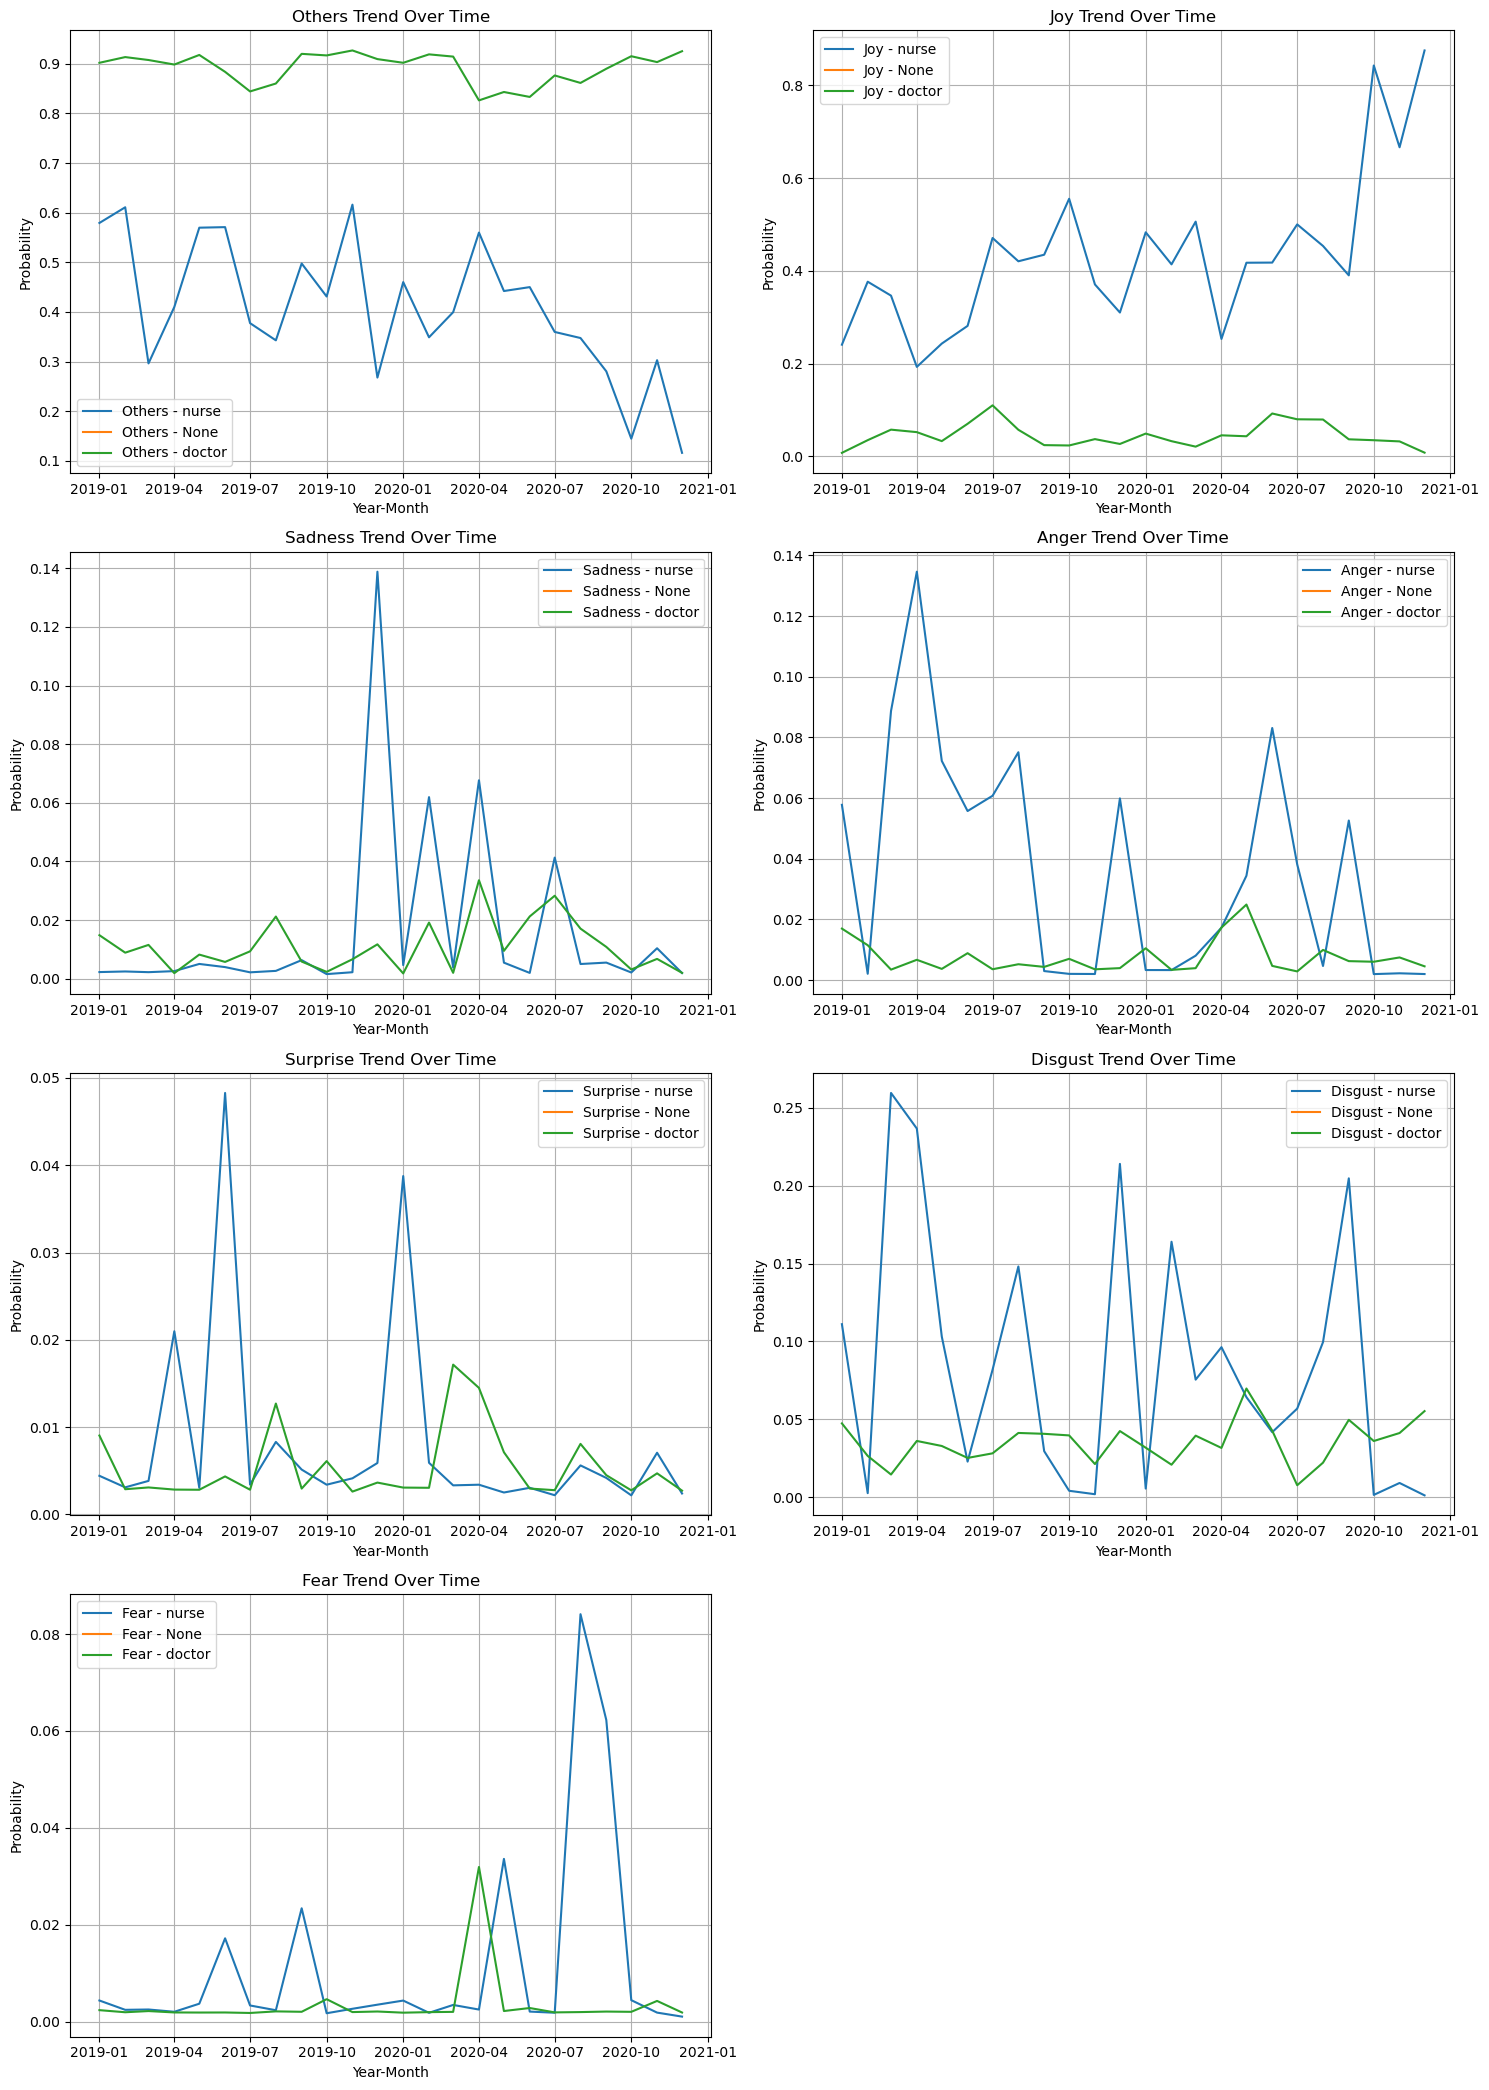

Processing and plotting results for sentiment...


/tmp/ipykernel_109863/1075247443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_date'] = pd.to_datetime(df['new_date'])
/tmp/ipykernel_109863/1075247443.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['new_date'].dt.to_period('M')
/tmp/ipykernel_109863/1075247443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Plot saved as: output_analysis2/sentiment_analysis_graphs/trends_plot.png


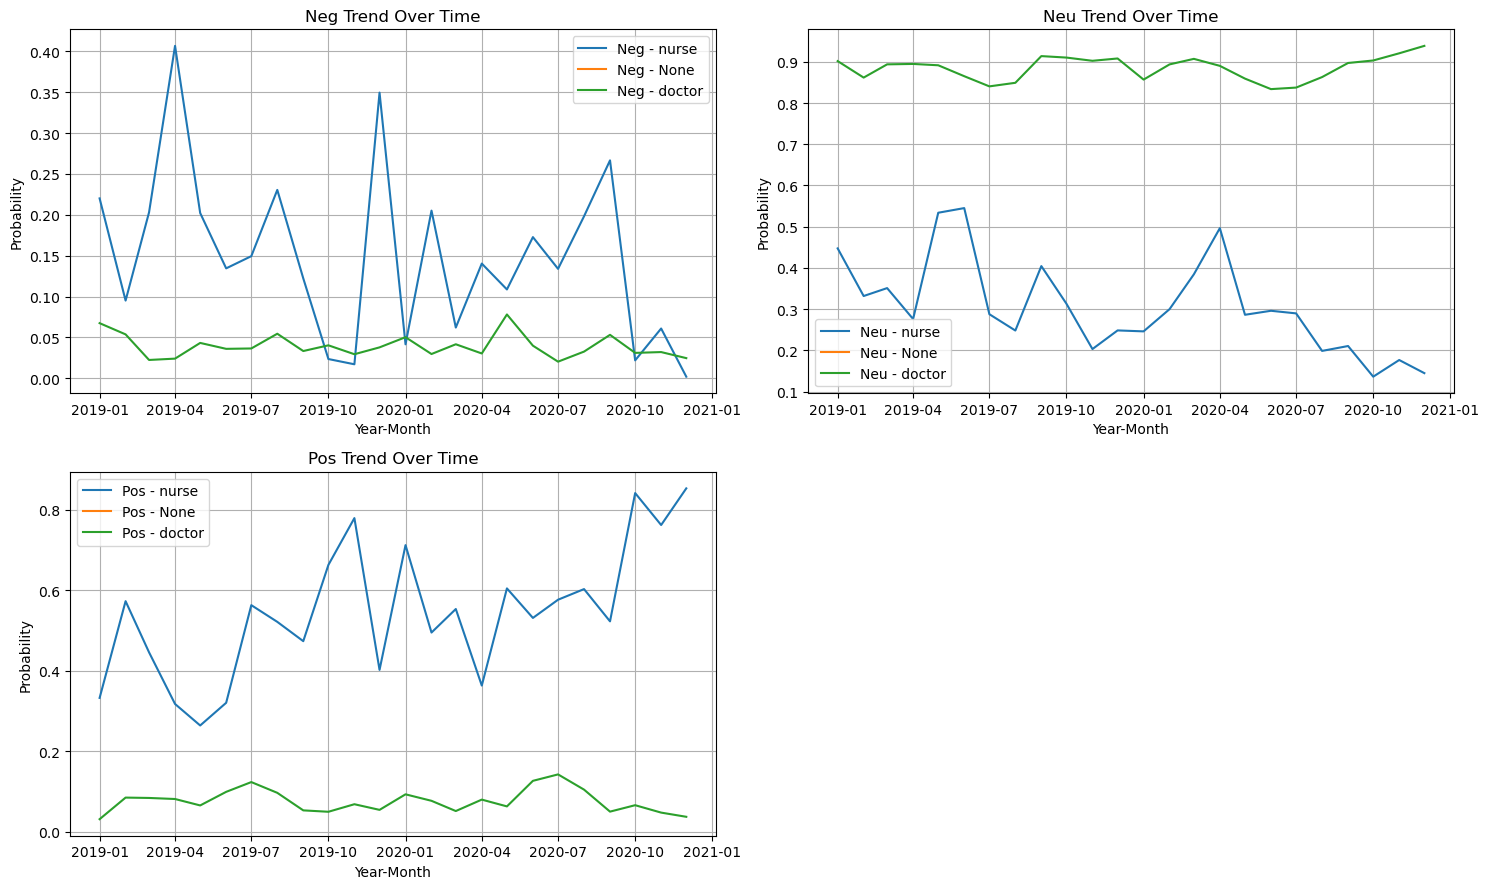

Processing and plotting results for hate_speech...


/tmp/ipykernel_109863/1075247443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_date'] = pd.to_datetime(df['new_date'])
/tmp/ipykernel_109863/1075247443.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['new_date'].dt.to_period('M')
/tmp/ipykernel_109863/1075247443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Plot saved as: output_analysis2/hate_speech_analysis_graphs/trends_plot.png


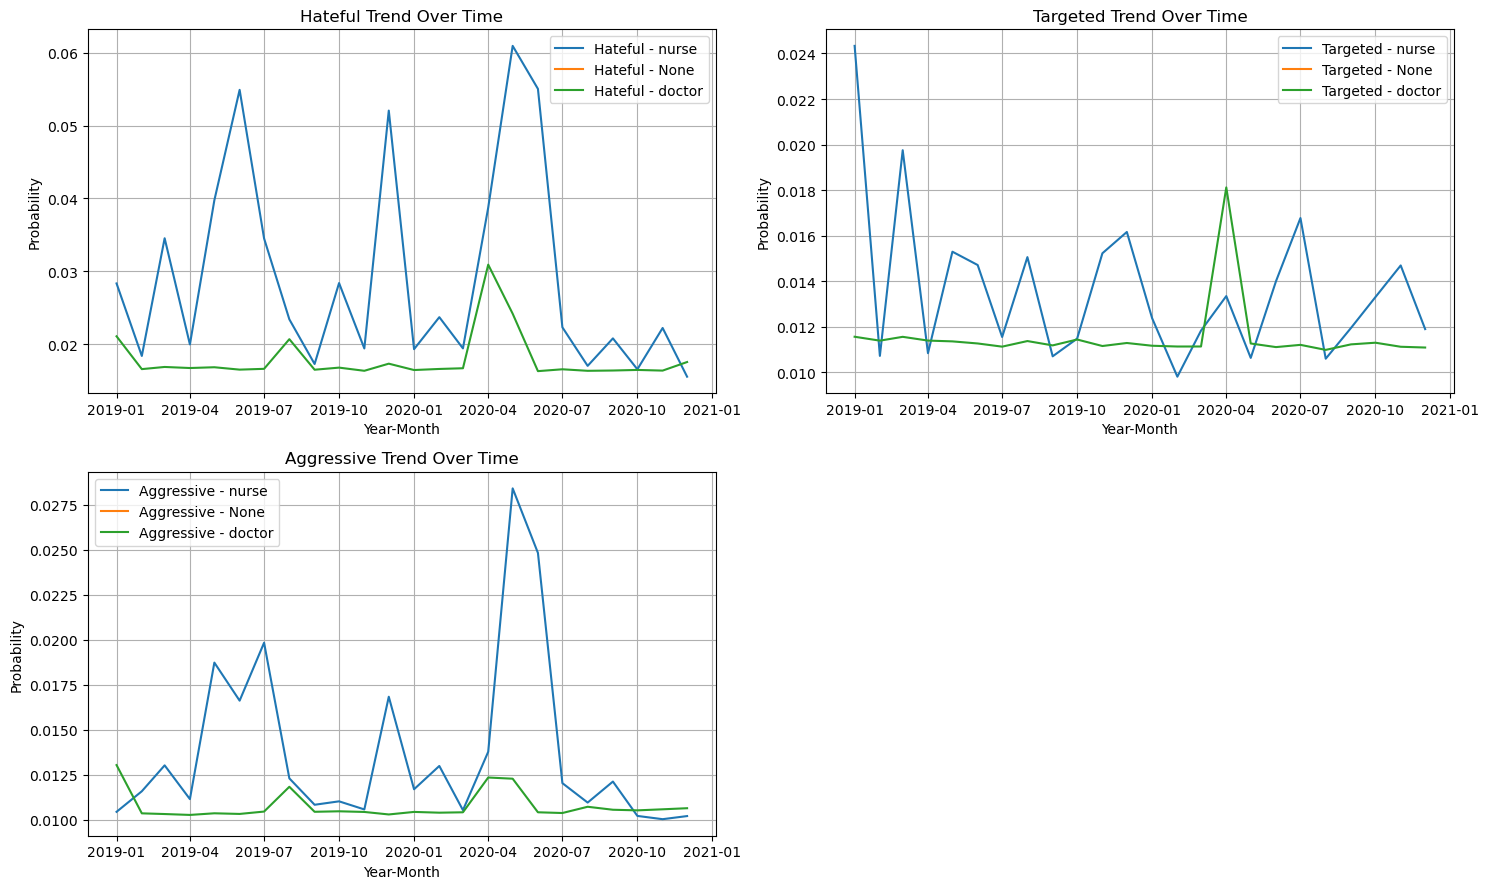

All outputs saved in: output_analysis2


In [16]:
# Main function to load data, preprocess, analyze multiple tasks, and plot
def main(db_path, save_dir="emotion_hate_sentiment_output", batch_size=1000, max_batches=10, num_files=10, checkpoint_file="posts_checkpoint.pkl"):
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
    os.makedirs(save_dir, exist_ok=True)

    print("Loading data from database in batches...")
    # Get an iterator for chunks from the load_data function
    tweets_iter, authors_df = load_data(db_path, chunksize=batch_size, checkpoint_file=checkpoint_file)
    
    # Process each chunk separately and then merge them at the end
    processed_chunks = []
    for i, tweets_chunk in enumerate(tweets_iter):
        if i >= max_batches:
            break
        print(f"Processing batch {i+1}...")
        
        # Preprocess the chunk (adjust according to your preprocess_data function)
        tweets_chunk = preprocess_data(tweets_chunk, authors_df)
        
        # Clean the text data in the 'content' column
        tweets_chunk['content'] = tweets_chunk['content'].apply(clean_text)
        
        # Handle date parsing: extract the date part and parse it
        tweets_chunk['new_date'] = tweets_chunk['date'].apply(lambda t: str(t).split(' ')[0])
        tweets_chunk['new_date'] = tweets_chunk['new_date'].apply(parse_date)
        
        processed_chunks.append(tweets_chunk)
    
    # Combine all processed chunks into one DataFrame for further processing
    tweets_df = pd.concat(processed_chunks, ignore_index=True)
    print(f"Combined processed tweets: {len(tweets_df)} rows.")

    # List of tasks to process
    tasks = ['emotion', 'sentiment', 'hate_speech']
    results_all_tasks = {}

    # Process tweets for each task
    for task in tasks:
        print(f"Processing tweets for {task}...")

        task_output_dir = os.path.join(save_dir, f"{task}_results")
        task_checkpoint_file = os.path.join(save_dir, f"{task}_checkpoint.pkl")

        process_tweets(
            tweets_df,
            task_output_dir,
            task_checkpoint_file,
            batch_size,
            max_batches,
            lang="en",
            task=task,
            num_files=num_files
        )

        task_files = [os.path.join(task_output_dir, f) for f in os.listdir(task_output_dir) if f.endswith('.csv')]
        task_results = pd.concat((pd.read_csv(f, sep=',') for f in task_files), ignore_index=True)
        results_all_tasks[task] = task_results

    group_names = authors_df['label'].unique().tolist()

    for task, task_results in results_all_tasks.items():
        print(f"Processing and plotting results for {task}...")
    
        # Dynamically handle task-specific columns
        task_columns = [col for col in task_results.columns if col not in ['author', 'new_date', 'content']]
    
        # Calculate monthly means per author first
        task_group_results = []
        for group_name in group_names:
            # Filter authors for the current group
            group_authors = authors_df[authors_df['label'] == group_name]['author_screen_name']
            group_data = task_results[task_results['author'].isin(group_authors)]
            
            # Calculate monthly means per author
            monthly_author_means = calculate_monthly_author_means(group_data, task_columns)
            
            # Calculate mean of means across all authors in the group
            group_means = calculate_mean_of_means(monthly_author_means, task_columns)
            task_group_results.append(group_means)
        
        # Save plots for the current task
        task_graph_output = os.path.join(save_dir, f"{task}_analysis_graphs")
        plot_trends(task_group_results, task_columns, group_names, task_graph_output)

    print(f"All outputs saved in: {save_dir}")


# Example usage
if __name__ == "__main__":
    db_path = "53k_individual_hcps_70_percent_confidence_tweets_2019_2022.db"
    main(db_path)
